In [8]:
import os
import pandas as pd
import configparser
#import mysql.connector
from sqlalchemy import create_engine, text as sql_text

import seaborn as sns
import matplotlib.pyplot as plt

config = configparser.ConfigParser()
config.read('..\\config.ini')

host = config['mysql']['host']
database = config['mysql']['database']
user = config['mysql']['user']
password = config['mysql']['password']
port = config['mysql']['port']

In [6]:
def read_query(query):
    engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}:{port}/{database}')
    df = pd.read_sql_query(sql = sql_text(query), con=engine.connect())
    print('Query Executed!')
    return df

The goal is to come up with a Collaborative Filtering recommender system. In the approach, we will need to analyze a customer's past transaction history and then compare them to other customers to identify trends and similarities. Based on the patterns we find, we can recommend new items to the customer that they may be interested in. 

More specifically, we cannot build a User-based CF where items are recommended to  a customer based on similarities between the user and the other users since we only know the age-group of the customers. Instead, we opt for item-based CF which recommends items to a user based on similarities between the items they have interacted with and other items they may like.

## Exploring article features:

In [3]:
q = """
SELECT 
    *
FROM
    articles
LIMIT 5;
"""

read_query(q)

Query Executed!


,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [4]:
q="""
SELECT 
    COUNT(*) AS total_items
FROM
    articles;
"""

read_query(q)

Query Executed!


,total_items
0,105542


There are a total of 105542 items.

According to the metadata, the images folder contains a folder of images corresponding to each `article_id` and are placed in subfolders starting with the first three digits of the article_id. Also, not all article_id values have a coressponding image.

Since we will only list articles with images on our website, we can first find the articles that have no corresponding images and just remove them from our dataset.

Getting the `article_id` of items that have a image:

In [5]:
location_of_subfolders = "..//h-and-m-personalized-fashion-recommendations//images"

# Get a list of all files in the folder
subfolder_names = os.listdir(location_of_subfolders)

all_articles = []

# Print the names of all files in the folder
for name in subfolder_names:
    location_of_images = os.path.join(location_of_subfolders,name)
    image_names = os.listdir(location_of_images)
    all_articles = all_articles + [int(x.replace('.jpg', '')) for x in image_names]

Total items with images available:

In [6]:
len(all_articles)

105100

So we will have a total of 105100 items to choose from and recommend! 442 tems are missing images and so we will remove them from our training set.

In [7]:
all_items = """
SELECT 
    *
FROM
    articles
"""

items_all = read_query(all_items)

Query Executed!


In [8]:
new_articles_df = items_all[items_all['article_id'].isin(all_articles)]

Saving our new table:

In [9]:
engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}:{port}/{database}')

new_articles_df.to_sql('articles_processed', engine, if_exists='replace', index=False)

105100

In [12]:
q = """
SELECT 
    index_group_name, COUNT(*) AS Total
FROM
    articles_processed
GROUP BY index_group_name;
"""

index_name = read_query(q)
index_name

Query Executed!


,index_group_name,Total
0,Ladieswear,39552
1,Baby/Children,34579
2,Menswear,12504
3,Sport,3381
4,Divided,15084


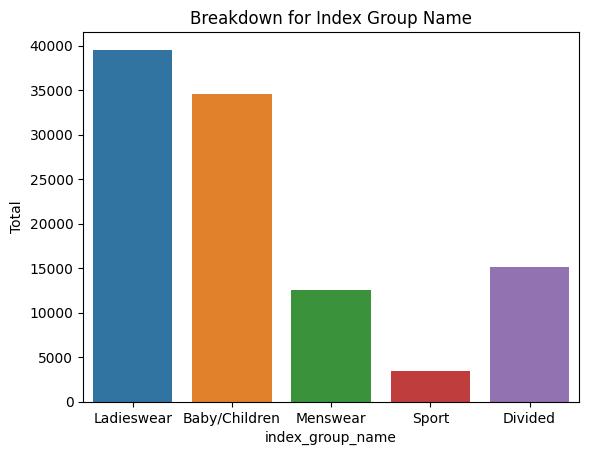

In [13]:
sns.barplot(x='index_group_name', y='Total', data=index_name)

plt.title('Breakdown for Index Group Name')
plt.show()

The store sells products that can be divided into 5 main groups: 'Ladieswear', 'Baby/Children', 'Menswear','Sport' and 'Divided'.

'Ladieswear' has the highest quantity while 'Sport' has the lowest quantity.

In [14]:
q = """
SELECT 
    product_type_name, COUNT(*) AS Total
FROM
    articles_processed
GROUP BY product_type_name;
"""

read_query(q)

Query Executed!


,product_type_name,Total
0,Vest top,2979
1,Bra,2210
2,Underwear Tights,544
3,Socks,1880
4,Leggings/Tights,1875
...,...,...
125,Bumbag,1
126,Eyeglasses,2
127,Wireless earphone case,2
128,Stain remover spray,2


There are a total of 130 differnt types of product.

In [16]:
q = """
SELECT 
    product_group_name, COUNT(*) AS Total
FROM
    articles_processed
GROUP BY product_group_name;
"""

product_group = read_query(q)
product_group

Query Executed!


,product_group_name,Total
0,Garment Upper body,42680
1,Underwear,5462
2,Socks & Tights,2431
3,Garment Lower body,19770
4,Accessories,11005
5,Items,17
6,Nightwear,1898
7,Unknown,121
8,Underwear/nightwear,54
9,Shoes,5156


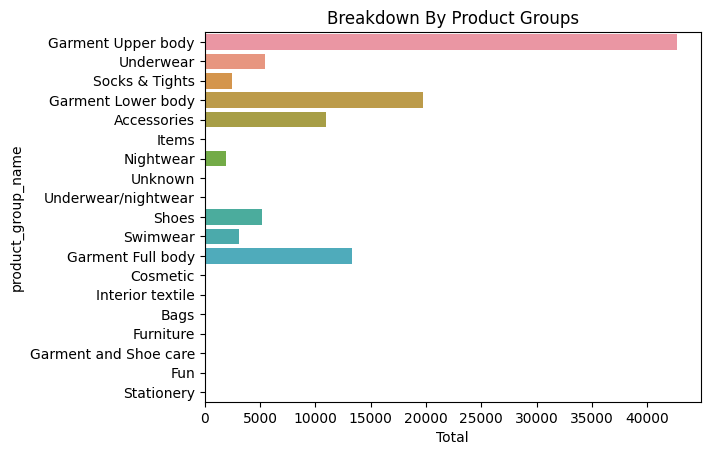

In [17]:
sns.barplot(y='product_group_name', x='Total', data=product_group)

plt.title('Breakdown By Product Groups')
plt.show()

The products can be grouped into 18 different product categories with most belonging to the 'Garment Upper Body' group.

In [18]:
q = """
SELECT 
    department_name, COUNT(*) AS Total
FROM
    articles_processed
GROUP BY department_name;
"""

read_query(q)

Query Executed!


,department_name,Total
0,Jersey Basic,1493
1,Clean Lingerie,238
2,Tights basic,221
3,Baby basics,1144
4,Casual Lingerie,853
...,...,...
243,Baby Girl Local Relevance,6
244,EQ Divided Blue,1
245,Kids Boy Exclusive,59
246,Accessories Other,1


There are a total of 248 different departments.

In [19]:
q = """
SELECT 
    section_name, COUNT(*) AS Total
FROM
    articles_processed
GROUP BY section_name;
"""

read_query(q)

Query Executed!


,section_name,Total
0,Womens Everyday Basics,1560
1,Womens Lingerie,3581
2,"Womens Nightwear, Socks & Tigh",1560
3,Baby Essentials & Complements,4916
4,Men Underwear,2311
5,Mama,2264
6,Womens Small accessories,3208
7,Men H&M Sport,871
8,Kids Boy,3325
9,Divided Basics,1714


There are a total of 56 differnt sections of products.

In [22]:
q = """
SELECT 
    garment_group_name, COUNT(*) AS Total
FROM
    articles_processed
GROUP BY garment_group_name;
"""

garment_group = read_query(q)

garment_group

Query Executed!


,garment_group_name,Total
0,Jersey Basic,8087
1,"Under-, Nightwear",7412
2,Socks and Tights,2258
3,Jersey Fancy,21415
4,Accessories,11365
5,Trousers Denim,3096
6,Outdoor,4501
7,Shoes,5021
8,Swimwear,2786
9,Knitwear,7480


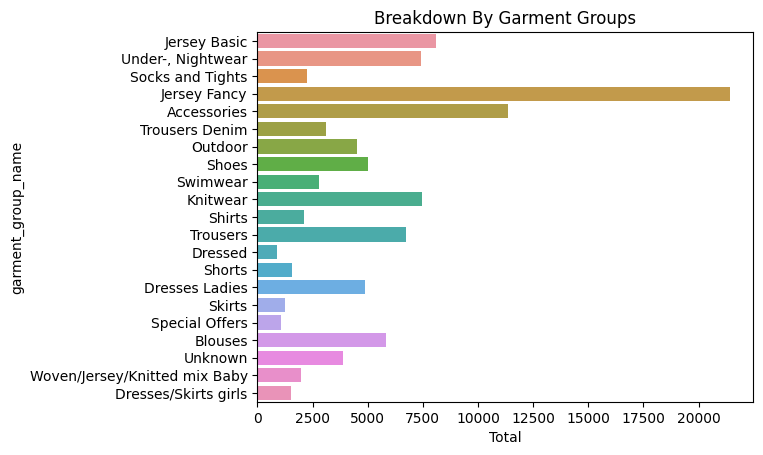

In [23]:
sns.barplot(y='garment_group_name', x='Total', data=garment_group)

plt.title('Breakdown By Garment Groups')
plt.show()

There are a total of 21 different garment groups.

Checking description column:

In [9]:
q = """
SELECT 
    article_id, detail_desc
FROM
    articles_processed
WHERE
    detail_desc IS NULL;
"""
def read_query(query):
    engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}:{port}/{database}')
    df = pd.read_sql_query(sql = sql_text(query), con=engine.connect())
    print('Query Executed!')
    return df

read_query(q)

Query Executed!


,article_id,detail_desc
0,351332007,None
1,420049002,None
2,420049003,None
3,426199002,None
4,426199010,None
...,...,...
399,752458001,None
400,768842001,None
401,768842004,None
402,856985001,None


There are 404 products with missing entries. So we will just remove these:

In [ ]:
q = """
DELETE FROM articles_processed 
WHERE
    article_id IN (SELECT 
        article_id
    FROM
        articles
    
    WHERE
        detail_desc IS NULL)
"""

read_query(q)

Checking now:

In [10]:
q = """
SELECT 
    article_id, detail_desc
FROM
    articles_processed
WHERE
    detail_desc IS NULL;
"""
def read_query(query):
    engine = create_engine(f'mysql+pymysql://{user}:{password}@{host}:{port}/{database}')
    df = pd.read_sql_query(sql = sql_text(query), con=engine.connect())
    print('Query Executed!')
    return df

read_query(q)

Query Executed!


,article_id,detail_desc


Are all the product descriptions unique?

In [11]:
q="""
SELECT 
    COUNT(detail_desc) AS total_products,
    COUNT(DISTINCT detail_desc) AS unique_products
FROM
    articles_processed
"""

read_query(q)

Query Executed!


,total_products,unique_products
0,104696,43283


We can see that there are 104696 different products but only 43283 unique descriptions of products.